In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as spla
# import torch
# import torchvision
import torchvision.datasets as datasets
from torchvision import transforms 
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
from numpy.polynomial.chebyshev import chebval
# from ml_collections import config_dict
import scipy.sparse as sparse
import os, sys
import time
from functools import partial
import ssgetpy
import copy

root_dir = r'../..'
SEED = 42

plt.rc('font', weight='bold', size=20) 
plt.rc('legend', fontsize=16)
plt.rc('lines', linewidth=3, markersize=9)
mpl.rcParams['axes.grid'] = True

markers = ['o','^','s','p','d']
colors = ['b','g','r','c','m','y']

# Utils

In [2]:
def power_iteration(A, Omega,p, krylov=False):
    '''
    A: ndarray(shape=(m,n))
    Omega: ndarray(shape=(n,l))
    p: non-negative int
    Acol: ndarray(shape=(m,l)), ((A@A.T)**p)@A@Omega with orthonormalization
    '''
    A = A.astype(np.double)
    Omega = Omega.astype(np.double)
    l = Omega.shape[-1]
    X = (A@Omega).astype(np.double) #(m,l)
    Qcol,_ = spla.qr(X, mode='economic').astype(np.double) #(m,l)
    for iter in range(p):
        if krylov:
            Qrow,_ = spla.qr(A.T@Qcol, mode='economic') #(n,l*(iter+1))
            Qcol,_ = spla.qr(A @ np.hstack((Qrow,Omega)),mode='economic') #(m,l*(iter+2))
        else:
            Qrow,_ = spla.qr(A.T@Qcol[:,-l:], mode='economic') #(n,l)
            Qcol,_ = spla.qr(A@Qrow,mode='economic') #(m,l)
        Qrow = Qrow.astype(np.double)
        Qcol = Qcol.astype(np.double)
    return Qcol.astype(np.double)


def rsvd(A, k, l=None, power_iter=0, algo='rsvd', return_Omega=0, 
         embedding=lambda d,l: np.random.randn(d,l)/np.sqrt(l)):
    '''
    * algo: 'rsvd'(default, Halko2011), 'gn'(generalized Nystrom), 'bk'(block Krylov)
    * return_Omega: 0 = not return, 1 = return embedding, 2 = return embedding + distribution
    '''
    A = A.astype(np.double)
    if l is None:
        l = min(k+10, A.shape[1])

    # construct low-rank approximation
    if algo=='bk': # block krylov (ignoring l)
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Qcol = power_iteration(A,Omega,power_iter,krylov=True) #(m,l*(p+1))
        Uap_reduced, sap, Vhap = spla.svd(Qcol.T @ A, full_matrices=False, lapack_driver='gesvd') #(l*(p+1),l*(p+1)),(l*(p+1),),(l*(p+1),n)
        Uap = (Qcol @ Uap_reduced).astype(np.double) #(m,l*(p+1))
    elif algo=='gn': # generalized Nystrom
        l_large = np.ceil(1.5*k)
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Gamma = embedding(A.shape[0],l_large).astype(np.double) #(m,l_large)
        Qcol = power_iteration(A,Omega,power_iter) #(m,l)
        Qrow = power_iteration(A.T,Gamma,0) #(n,l_large)
        core = ((Qcol.T @ A) @ Qrow).astype(np.double) #(l,l_large)
        Uap_reduced, sap, Vhap_reduced = spla.svd(core, full_matrices=False, lapack_driver='gesvd') #(l,l),(l,),(l,l_large)
        Uap = (Qcol @ Uap_reduced).astype(np.double) #(m,l)
        Vhap = (Vhap_reduced @ Qrow.T).astype(np.double) #(l,n)
    else: # rsvd
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Qcol = power_iteration(A,Omega,power_iter) #(m,l)
        Uap_reduced, sap, Vhap = spla.svd(Qcol.T @ A, full_matrices=False, lapack_driver='gesvd') #(l,l),(l,),(l,n)
        Uap = (Qcol @ Uap_reduced).astype(np.double) #(m,l)
    
    # output
    if return_Omega==1:
        return Uap, sap, Vhap, Omega
    elif return_Omega==2:
        return Uap, sap, Vhap, Omega, embedding
    else:
        return Uap, sap, Vhap


def lupp(A):
    '''
    A of size mxk with rank k and m >= k
    
    A[p,:] = L@U
    p: ndarray(shape=(m,), dtype=int)
    L: ndarray(shape=(m,k), dtype=float)
    U: ndarray(shape=(k,k), dtype=float)
    '''
    A = A.astype(np.double)
    P, L, U = spla.lu(A)
    p = (P.T @ np.arange(A.shape[0]).reshape(-1,1)).astype(int).reshape(-1)
    return L.astype(np.double), U.astype(np.double), p


def cpqr(A):
    '''
    A of size kxn with rank k and n >= k
    
    A[:,p] = Q@R
    p: ndarray(shape=(n,), dtype=int)
    Q: ndarray(shape=(k,k), dtype=float)
    R: ndarray(shape=(k,n), dtype=float)
    '''
    A = A.astype(np.double)
    Q,R,p = spla.qr(A, mode='economic', pivoting=True)
    return Q.astype(np.double), R.astype(np.double), p.astype(int)


def stable_id_error(A, row_idx, timing=False, ord='fro'):
    A = A.astype(np.double)
    R = A[row_idx,:] #(k,n)
    t0 = time.time()
    Qr, _ = spla.qr(R.T, mode='economic') #(n,k)
    Qr = Qr.astype(np.double)
    A_sid = (A @ Qr) @ Qr.T 
    dt = time.time() - t0
    error = spla.norm(A - A_sid, ord=ord)
    if timing:
        return error, dt
    else:
        return error


def matdivide(A,B, compute_spectrum=False, tol=1e-16):
    '''
    A: (m,n) ndarray
    B: (k,n) ndarray
    compute A*pinv(B), or its spectrum
    '''
    A = A.astype(np.double)
    B = B.astype(np.double)
    U,s,Vh = spla.svd(B, full_matrices=False, lapack_driver='gesvd')
    r = np.count_nonzero(s>tol)
    Aux = ((A @ Vh[:r].T)/(s[:r].reshape(1,-1))).astype(np.double) #(m,r)
    if compute_spectrum:
        spectrum = spla.svd(Aux, compute_uv=False, lapack_driver='gesvd')
        return spectrum
    else:
        return (Aux @ U[:,:r].T).astype(np.double) #(m,k)


def canonical_angles(U,V, check_ortho=True, tol=1e-16):
    '''
    Input
    -----
    * U: ndarray(shape=(d,k)) (d>k)
    * V: ndarray(shape=(d,l)) (d>l)
    Output
    ------
    * min(k,l) sin's and cos's, descending
    '''
    U = U.astype(np.double)
    V = V.astype(np.double)
    if check_ortho:
        U,_ = spla.qr(U, mode='economic')
        V,_ = spla.qr(V, mode='economic')
    Mcos = (U.T @ V).astype(np.double) # (k,l)
    cos = spla.svd(Mcos, full_matrices=False, compute_uv=False, lapack_driver='gesvd')
    if cos[0]>=1. or cos[-1]<tol: # compute sin instead for highly overlapped (U,V)
        if U.shape[-1]>V.shape[-1]: #k>l
            Msin = V - U @ Mcos #(d,l)
        else: #l>=k
            Msin = U - V @ Mcos.T #(d,k)
        sin = spla.svd(Msin, full_matrices=False, compute_uv=False, lapack_driver='gesvd')
        return np.flip(sin)
    else:
        return np.sqrt(1.-cos**2)
    

get_sketch = lambda A, sample_size: A @ (np.random.randn(A.shape[1], sample_size)/np.sqrt(sample_size)).astype(np.double)

# Target matrices
## Featch [SparseSuite](https://sparse.tamu.edu/)

In [3]:
# https://sparse.tamu.edu/Meszaros/large
# results = ssgetpy.search(
#     rowbounds = (4200, 4300), # 4,282
#     colbounds = (8600, 8700), # 8,617
#     nzbounds = (20600, 20800), # 20,635
#     isspd = False,
#     dtype = None,
#     group = None,
#     kind = None,
#     limit = 10,
# )
# large = results[0]
# large.download(destpath=os.path.join(root_dir, 'dataset'))


## Formating

Files already downloaded and verified


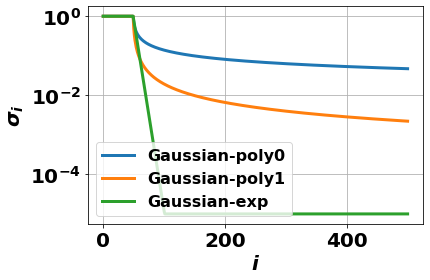

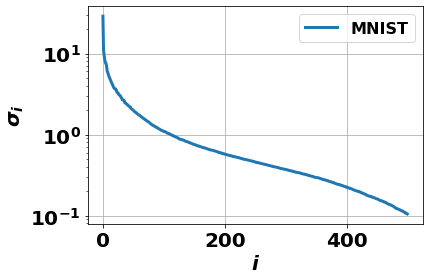

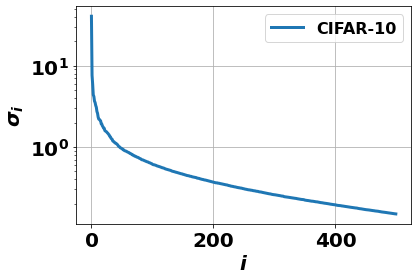

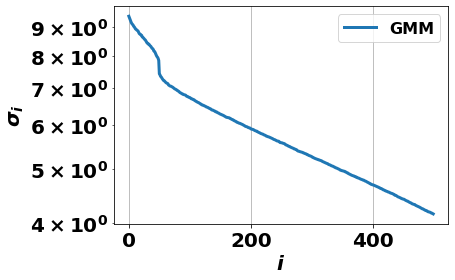

odict_keys(['Gaussian-poly0', 'Gaussian-poly1', 'Gaussian-exp', 'SNN_m2000n1000r50a10', 'SNN_m2000n1000r50a1', 'MNIST', 'cifar10', 'gmm'])


In [5]:
def genenrate_mnist_target(size=800):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    dataset = datasets.MNIST(root=os.path.join(root_dir,'dataset'), train=False, download=True, transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=size, shuffle=True)
    X,_ = next(iter(dataloader))
    X = X.view(size,-1).numpy().astype(np.double)
    X = X / spla.norm(X, ord=2, axis=1, keepdims=True)
    U,s,Vh = spla.svd(X, full_matrices=False, lapack_driver='gesvd')
    target = {'A': X.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': 'mnist-train%d'%(size)}
    return target


def genenrate_cifar10_target(size=2000):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    dataset = datasets.CIFAR10(root=os.path.join(root_dir,'dataset'), train=False, download=True, transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=size, shuffle=True)
    X,_ = next(iter(dataloader))
    X = X.view(size,-1).numpy().astype(np.double)
    X = X / spla.norm(X, ord=2, axis=1, keepdims=True)
    U,s,Vh = spla.svd(X, full_matrices=False, lapack_driver='gesvd')
    target = {'A': X.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': 'mnist-train%d'%(size)}
    return target


def genenrate_gmm_target(n=2000, d=500, n_cluster=100, sigma=0.5):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    X = np.repeat(np.eye(d)[:n_cluster], repeats=n//n_cluster, axis=0) # cluster centers
    n, d = X.shape
    X += np.random.randn(n,d) * sigma
    U,s,Vh = spla.svd(X, full_matrices=False, lapack_driver='gesvd')
    target = {'A': X.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': f'gmm-n{n}d{d}k{n_cluster}sig{sigma:.0e}'}
    return target


def genenrate_gaussian_target(m=1000, n=1000, rank=1000, spectrum=None):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    if spectrum is None:
        spectrum = np.linspace(1.0, 1e-5, num=rank)
    elif len(spectrum)<rank:
        spectrum = np.concatenate((spectrum, np.zeros(rank-len(spectrum))))
    U,_ = spla.qr(np.random.randn(m,rank), mode='economic')
    V,_ = spla.qr(np.random.randn(n,rank), mode='economic')
    target = {'A': (( U*(spectrum[:rank].reshape((1,-1))) )@V.T).astype(np.double), 
              'U': U.astype(np.double), 
              's': spectrum[:rank].astype(np.double),
              'V': V.astype(np.double),
              'tag': 'Gaussian'}
    return target


def generate_sparse_nonnegative_target(m=1000, n=1000, r1=100, amp=1., sparsity=0.1):
    r = min(m,n)
    weights = np.concatenate((amp/np.arange(1,r1+1), 1./np.arange(r1+1,r+1))) #(r,)
    X = sparse.random(m, r, density=sparsity, format='csr').toarray()
    Y = sparse.random(r, n, density=sparsity, format='csr').toarray()
    A = (X@(weights*Y))
    U,s,Vh = spla.svd(A, full_matrices=False, lapack_driver='gesvd')
    target = {'A': A.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': f'SNN-m{m:d}n{n:d}r{r1:d}a{amp:.0f}'}
    return target


def visualize_spec(spectra, range=100):
    plt.figure()
    for name, spec in spectra.items():
        plt.semilogy(spec[:range], label=name)
    plt.xlabel('$i$')
    plt.ylabel('$\sigma_i$')
    plt.legend()
    plt.show()


def get_targets(m=2000, n=1000, r1=50, verbose=False, tol=1e-5):
    spectra= {  'poly0': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./(np.arange(2,r-r1+2))**.5))),
                'poly1': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./np.arange(2,r-r1+2)))),
                'poly2': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./(np.arange(2,r-r1+2))**2))),
                'exp': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,0.8**(np.arange(1,r-r1+1))))),
              }
    targets = OrderedDict()
    # Gaussian random
    spectra_gaussian = dict()
    r = min(m,n)
    for decay in ['poly0','poly1','exp']:
        tag = f'Gaussian-{decay:s}'
        targets[tag] = genenrate_gaussian_target(m=m, n=n, rank=r, spectrum=spectra[decay](r))
        targets[tag]['tag'] = tag 
        spectra_gaussian[tag] = targets[tag]['s']
    
    # SNN
    spectra_snn = dict()
    for amp in [10,1]:
        tag = f'SNN_m{m:d}n{n:d}r{r1:d}a{amp:.0f}'
        targets[tag] = generate_sparse_nonnegative_target(m, n, r1, amp, sparsity=0.1)
        spectra_snn[tag] = targets[tag]['s']
    
    # MNIST
    targets['MNIST'] = genenrate_mnist_target(size=m)
    
    # CIFAR-10
    targets['cifar10'] = genenrate_cifar10_target(size=m)
    
    # GMM
    targets['gmm'] = genenrate_gmm_target(n=m, d=n, n_cluster=50, sigma=0.1)
    
    if verbose:
        visualize_spec(spectra_gaussian, range=500)
        # visualize_spec(spectra_snn, range=100)
        visualize_spec({'MNIST':targets['MNIST']['s']}, range=500)
        visualize_spec({'CIFAR-10':targets['cifar10']['s']}, range=500)
        visualize_spec({'GMM':targets['gmm']['s']}, range=500)

    return targets


targets = get_targets(verbose=True)
print(targets.keys())

# Blocked RLUPP

In [8]:
def blocked_rlupp_id_local(A, tol, b=10, mode='lu', record_error=True, verbose=False):
    '''
    mode: 'id' / 'lu'
    '''
    A = A.astype(np.double)
    sample = get_sketch(A, b)
    residual = sample
    skeletons = np.array([])
    candidates = np.arange(A.shape[0]).astype(int)
    W = None
    L = None

    errs_est = []
    errs_id = []
    errs_sid = []

    for t in range(A.shape[0]//b):
        L_t, U_t, p_row = lupp(residual) # residual(m-bt,b), L_t(m-bt,b), U_t(b,b), p_row(m-bt,)
        
        # interpolation matrix
        W_local = np.zeros((A.shape[0], b))
        W_sub = spla.solve_triangular(L_t[:b,:].T, L_t[b:,:].T).T # 'tri_solv'
        # W_sub = matdivide(L_t[b:,:], L_t[:b,:]) # 'stable_inv'
        W_local[candidates[p_row],:] = np.vstack((np.eye(b, dtype=np.double), W_sub))
        if W is None:
            W = W_local 
        else: 
            W[candidates[p_row],:] = W[candidates,:]
            W = np.hstack((W, W_local)) # (m, b(t+1))
        W = W.astype(np.double)
        
        # LU
        if L is None:
            L = L_t  
        else: 
            candidates_local = np.arange(len(skeletons), A.shape[0], dtype=int) #(m-bt,)
            L[candidates_local,:] = L[candidates_local[p_row],:]
            L = np.hstack((L, np.vstack((np.zeros((A.shape[0]-L_t.shape[0],b), dtype=np.double), L_t))))
        L = L.astype(np.double) # (m, b(t+1))
                
        # skeleton indices
        skeletons = np.concatenate((skeletons, candidates[p_row[:b]])).astype(int) # (b(t+1),)
        candidates = candidates[p_row[b:]].astype(int) # (b(m-t-1),)
        
        sample = get_sketch(A, b)
        if mode=='id':
            residual = sample[candidates,:] - W[candidates,:] @ sample[skeletons,:]
            # residual = sample[candidates,:] - matdivide(A[candidates,:], A[skeletons,:]) @ sample[skeletons,:] # stable but slow
        elif mode=='lu':
            L1_t = L[:L.shape[1],:]
            L2_t = L[L.shape[1]:,:]
            residual = sample[candidates,:] - L2_t @ spla.solve_triangular(L1_t, sample[skeletons,:], lower=True)
        else:
            raise ValueError(f'Mode {mode:s} undefined. Available choices: id / lu')
        
        err_est = spla.norm(residual, ord='fro')
        err_id = spla.norm(A - W @ A[skeletons,:], ord='fro')
        err_sid = stable_id_error(A, skeletons)
        
        errs_est.append(err_est)
        errs_id.append(err_id)
        errs_sid.append(err_sid)
        
        if err_est < tol:
            break
        elif verbose:
            print(f'Iteration {t:3d} | Approx rank = {len(skeletons):d} | Error estimation = {err_est:6.2e} | Stable ID error = {err_sid:6.2e}')
    
    ranks = np.arange(1,t+2)*b     
    errs_est = np.array(errs_est)
    errs_id = np.array(errs_id)
    errs_sid = np.array(errs_sid)

    if record_error:
        return W, skeletons, candidates, ranks, errs_est, errs_id, errs_sid
    else: 
        return W, skeletons, candidates
   
   
def blocked_rlupp_id(A, tol, b=10, record_error=True, verbose=False, num_smp=5):
    A = A.astype(np.double)
    sample = get_sketch(A, b)
    residual = sample
    skeletons = np.array([])
    candidates = np.arange(A.shape[0]).astype(int)
    W = None
    L = None

    errs_est = []
    errs_id = []
    errs_sid = []

    for t in range(A.shape[0]//b):
        L_t, _, p_row = lupp(residual) # residual(m-bt,b), L_t(m-bt,b), U_t(b,b), p_row(m-bt,)
        
        # LU
        if L is None:
            L = L_t  
        else: 
            candidates_local = np.arange(len(skeletons), A.shape[0], dtype=int) #(m-bt,)
            L[candidates_local,:] = L[candidates_local[p_row],:]
            L = np.hstack((L, np.vstack((np.zeros((A.shape[0]-L_t.shape[0],b), dtype=np.double), L_t))))
        L = L.astype(np.double) # (m, b(t+1))
                
        # skeleton indices
        skeletons = np.concatenate((skeletons, candidates[p_row[:b]])).astype(int) # (b(t+1),)
        candidates = candidates[p_row[b:]].astype(int) # (b(m-t-1),)
        err_sid = stable_id_error(A, skeletons)
        
        # unbiased estimate
        L1_t = L[:L.shape[1],:]
        L2_t = L[L.shape[1]:,:]
        err_estimates = []
        for _ in range(num_smp):
            sample = get_sketch(A, b)
            residual = sample[candidates,:] - L2_t @ spla.solve_triangular(L1_t, sample[skeletons,:], lower=True)
            err_est = spla.norm(residual, ord='fro')
            err_estimates.append(err_est)
        
        # ID
        ID_residual = A[candidates,:] - L2_t @ spla.solve_triangular(L1_t, A[skeletons,:], lower=True)
        err_id = spla.norm(ID_residual, ord='fro')
        
        errs_est.append(err_estimates)
        errs_id.append(err_id)
        errs_sid.append(err_sid)
        
        if err_est < tol:
            break
        elif verbose:
            print(f'Iteration {t:3d} | Approx rank = {len(skeletons):d} | Error estimation = {(sum(err_estimates)/len(err_estimates)):6.2e} | Stable ID error = {err_sid:6.2e}')
    
    ranks = np.arange(1,len(errs_sid)+1)*b 
    errors = {
        'blu_id': np.array(errs_id),
        'blu_res': np.array(errs_est).T,
        'blu_psid': np.array(errs_sid),
    }

    if record_error:
        return W, skeletons, candidates, ranks, errors
    else: 
        return W, skeletons, candidates
   

# Sketchy LUPP/CPQR

In [134]:
def interpolation(A, row_perm, k, Y=None, oversampling=1.0, mode='sid', timing=True):
    '''
    * A: (m,n)
    * row_perm: (m,)
    * k: int
    * Y: (m,?), treated as the triangular matrix from LUPP/CPQR if mode=='id'
    '''
    l = int(np.ceil(k*oversampling)) 
    if mode in ['qrid', 'fsid']:
        Y = get_sketch(A, l).astype(np.double) if Y is None else Y[:,:l]
        
    t0 = time.time()
    if mode=='qrid':
        R = spla.qr(Y[row_perm][:,:l].T, mode='r') #cost: (ml^2)
        R = R[0] #(k,m)
        R1 = R[:k,:k] #(k,k)
        R2 = R[:k,k:] #(k,m-k)
        W_perm_sub = spla.solve_triangular(R1, R2).T #(m-k,k)
    elif mode=='sid':
        As = A[row_perm[:k]].T #(n,k)
        Q, R = spla.qr(As, mode='economic',) #(n,k), (k,k)
        W_perm_sub = spla.solve_triangular(R, (A[row_perm[k:]]@Q).T).T #(m-k,k)
    elif mode=='fsid':
        Ys = Y[row_perm[:k],:l].T #(l,k)
        Q, R = spla.qr(Ys, mode='economic',) #(l,k), (k,k)
        W_perm_sub = spla.solve_triangular(R, (Y[row_perm[k:],:l]@Q).T).T #(m-k,k)
    elif mode=='id':
        L = Y
        W_perm_sub = spla.solve_triangular(L[:k,:k].T, L[k:,:k].T).T
    else:
        raise RuntimeError(f"Algorithm '{mode}' not recognized")
    dt = time.time() - t0
        
    if timing:
        return W_perm_sub, dt
    else:
        return W_perm_sub


def id_error(X, row_perm, W_perm_sub, mode='ls'):
    '''
    * mode
        - psd: trace of PSD matrix X @ X.T - W @ Xs @ (W @ Xs).T
        - ls: least square / Frobenius norm error of A
    '''
    k = len(row_perm) - W_perm_sub.shape[0]
    if mode=='psd':
        err = spla.norm(X[row_perm[k:]], ord='fro')**2 - spla.norm(W_perm_sub @ X[row_perm[:k]], ord='fro')**2
    elif mode=='ls':
        err = spla.norm(X[row_perm[k:]] - W_perm_sub @ X[row_perm[:k]], ord='fro')**2
    else:
        raise RuntimeError(f"Error metric '{mode}' not recognized")
    return err


def lupp_uest(U, num_pts, k, u_est_offset=5):
    t0 = time.time()
    if k<np.min(U.shape):
        offset = min(k + u_est_offset, np.min(U.shape))-k
        # u_est = spla.norm(U[r,r:], ord=2)
        # u_est = spla.norm(U[r:,r:], axis=1, ord=2).max()
        # u_est = spla.norm(U[r:,r:], ord='fro')
        # u_est = spla.norm(U[r, r:], ord=2)
        # u_est = spla.norm(U[r:r+offset, r:r+offset], axis=1, ord=2).max()
        u_est = spla.norm(U[k:k+offset, k:k+offset], ord='fro')
    else:
        offset = 1
        u_est = np.abs(U[-1,-1])
    dt = time.time() - t0
    err_est = u_est * np.sqrt((num_pts-k) * offset)
    return err_est, dt
    

def get_id_error(
    A, ranks, oversampling=1.0, u_est_offset=5,
    modes=['lupp', 'cpqr', 'detcpqr'], 
    errtags = ['id', 'sid', 'fsid', 'uest'], # psid
):
    A = A.astype(np.double)   
    error_ref = spla.norm(A, ord='fro')**2
    k_max = np.max(ranks)
    t0 = time.time()
    Y = get_sketch(A, min(k_max*2, A.shape[1])).astype(np.double)
    dt_sketch_unit = (time.time() - t0) / Y.shape[1]
    errors = dict()
    times = dict()
    
    for mode in modes:
        if mode=='lupp':        
            def _lupp_error_time(errtag):
                errs_id = []
                dts_id = []
                for k in ranks:
                    t0 = time.time()
                    L, U, row_perm = lupp(Y[:,:k]) #(m,k) cost: (mk^2)
                    dt_pivot = time.time() - t0
                    
                    if errtag=='uest':
                        err_id, dt_id = lupp_uest(U, A.shape[0], k, u_est_offset=u_est_offset)
                    elif errtag=='psid':
                        err_id, dt_id = stable_id_error(A, row_perm[:k], timing=True)
                    elif errtag=='id':
                        W_perm_sub, dt_id = interpolation(A, row_perm, k, Y=L, mode=errtag)
                        err_id = id_error(A, row_perm, W_perm_sub)
                    else:
                        W_perm_sub, dt_id = interpolation(A, row_perm, k, Y=Y, oversampling=oversampling, mode=errtag,)
                        err_id = id_error(A, row_perm, W_perm_sub)
                    errs_id.append(err_id)  
                    
                    if errtag=='fsid':
                        dts_id.append(dt_pivot + dt_id + dt_sketch_unit*np.ceil(k*oversampling))
                    else:
                        dts_id.append(dt_pivot + dt_id + dt_sketch_unit*k)
                return np.array(errs_id), np.array(dts_id)
            
            for errtag in errtags:
                tag = f'{mode}_{errtag}'
                errs_id, dts_id = _lupp_error_time(errtag)
                errors[tag] = errs_id / error_ref
                times[tag] = dts_id
                
        elif mode=='cpqr':
            def _cpqr_error_time(errtag):
                errs_id = []
                dts_id = []
                for k in ranks:
                    t0 = time.time()
                    _, R, row_perm = cpqr(Y[:,:k].T) #R:(k,m) # QR has to be computed per-rank since each pivot is determined by a global search
                    dt_pivot = time.time() - t0
                    
                    if errtag=='id':
                        W_perm_sub, dt_id = interpolation(A, row_perm, k, Y=R.T, mode=errtag) #(m-k,k)
                    else:
                        W_perm_sub, dt_id = interpolation(A, row_perm, k, Y=Y, oversampling=oversampling, mode=errtag,)
                    errs_id.append(id_error(A, row_perm, W_perm_sub))  
                    
                    if errtag=='fsid':
                        dts_id.append(dt_pivot + dt_id + dt_sketch_unit*np.ceil(k*oversampling))
                    else:
                        dts_id.append(dt_pivot + dt_id + dt_sketch_unit*k)
                return np.array(errs_id), np.array(dts_id)
            
            for errtag in errtags:
                if errtag in ['id','sid']:
                    tag = f'{mode}_{errtag}'
                    errs_id, dts = _cpqr_error_time(errtag)
                    errors[tag] = errs_id / error_ref
                    times[tag] = dts
                
        elif mode=='detcpqr':        
            def _id_error_time(errtag):
                errs_id = []
                dts_id = []
                
                t0 = time.time()
                _, R, row_perm = cpqr(A.T) #(m,m) if m<n else (n,m)
                dt_pivot = time.time() - t0
            
                for k in ranks:
                    if errtag=='id':
                        W_perm_sub, dt_id = interpolation(A, row_perm, k, Y=R[:k].T, mode=errtag)
                    else:
                        W_perm_sub, dt_id = interpolation(A, row_perm, k, Y=Y, oversampling=oversampling, mode=errtag,)
                    err_id = id_error(A, row_perm, W_perm_sub)
                    errs_id.append(err_id)  
                    dts_id.append(dt_pivot + dt_id)
                return np.array(errs_id), np.array(dts_id)
            
            for errtag in errtags:
                if errtag in ['id','sid']:
                    tag = f'{mode}_{errtag}'
                    errs_id, dts_id = _id_error_time(errtag)
                    errors[tag] = errs_id / error_ref
                    times[tag] = dts_id
            
        else:
            raise RuntimeError(f"Pivoting method '{mode}' not recognized")
    
    return errors, times

# Cholesky ID
The following functions adapt [the implementation of (blocked) RPCholesky](https://github.com/eepperly/Randomly-Pivoted-Cholesky/blob/main/rp_cholesky.py) for PSD matrices to Cholesky ID for generic matrices.

In [256]:
def cholid(X, k, tol=None, mode='rp', ortho=0):
    '''
    * X: ndarray(n,d)
    * k: target rank
    * mode: choices=['rp','greedy']
    * ortho: whether using ORP/OGP
        - ortho==-1: RP/GP, faster when n < d
        - ortho==0: ORP/OGP, faster when n > d
        - ortho>0: using ORP/OGP, calibrate diags every <ortho> steps with cost O(ni) (experiments suggest unnecessary)
    '''
    X = X.astype(np.double)
    n, d = X.shape
    row_perm = np.arange(n)
    rng = np.random.default_rng(seed=SEED)
    
    t0 = time.time()
    diags = spla.norm(X, ord=2, axis=1).astype(np.double)**2 #(n,)
    residual = sum(diags)
    dt_init = time.time() - t0
    time_pivot = [dt_init]
    if ortho>0:
        diags0 = copy.deepcopy(diags)
    
    L = np.zeros((n,k)).astype(np.double)
    Q = np.zeros((d,k))
    residuals = [residual]
    for i in range(k):
        candidates = row_perm[i:]
        if mode == 'rp':
            j = i + rng.choice(n-i, p = diags[candidates] / sum(diags[candidates]))
        elif mode == 'greedy':
            j = i + rng.choice(np.where(diags[candidates] == np.max(diags[candidates]))[0])
        else:
            raise RuntimeError(f"Algorithm '{mode}' not recognized")
        row_perm[[i, j]] = row_perm[[j, i]]
        idx = row_perm[i]
        
        t0 = time.time()
        if ortho >= 0:
            if i==0:
                v = X[idx]
            else:
                v = X[idx] - Q[:,:i] @ (Q[:,:i].T @ X[idx])
            Q[:,i] = v / np.sqrt(np.sum(v**2))
            a = X[row_perm[i:]] @ v
        else:
            a = X[row_perm[i:]] @ X[idx].T - L[row_perm[i:],:i] @ L[idx,:i].T
        L[row_perm[i:],i] = (a / np.sqrt(a[0])).astype(np.double)
        # L[row_perm[i:],i] = (a / np.sqrt(diags[idx])).astype(np.double)
        
        if (ortho < 1) or (i < ortho) or (i % ortho!=0):
            diags[row_perm[i+1:]] -= L[row_perm[i+1:],i]**2
        else:
            diags[row_perm[i+1:]] = diags0[row_perm[i+1:]] - spla.norm(L[row_perm[i+1:],:i+1], ord=2, axis=1)**2
            
        diags[idx] = 0 # for sanity only
        diags = diags.clip(min=0)
        diags = diags.astype(np.double)
        residual = sum(diags[row_perm[i+1:]])
        time_pivot.append(time.time() - t0 + time_pivot[-1])
        
        residuals.append(residual)
        if tol is not None and residual < residuals[0] * tol:
            L = L[:,:i+1]
            # Q = Q[:,:i+1]
            break
        
    residuals = np.array(residuals[1:])/residuals[0]
    time_pivot = np.array(time_pivot[1:])
    
    return row_perm, L, residuals, time_pivot


def blocked_cholid(X, k, b=10, tol=None, mode='rp', ortho=0):
    '''
    * X: ndarray(n,d)
    * k: target rank
    * mode: choices=['rp','greedy']
    * ortho: whether using ORP/OGP
        - ortho==-1: RP/GP, faster when n < d
        - ortho==0: ORP/OGP, faster when n > d
        - ortho>0: using ORP/OGP, calibrate diags every <ortho> steps with cost O(ni) (experiments suggest unnecessary)
    '''
    X = X.astype(np.double)
    n, d = X.shape
    row_perm = np.arange(n)
    rng = np.random.default_rng(seed=SEED)
    
    t0 = time.time()
    diags = spla.norm(X, ord=2, axis=1).astype(np.double)**2 #(n,)
    residual = sum(diags)
    dt_init = time.time() - t0
    time_pivot = [dt_init]
    if ortho>0:
        diags0 = copy.deepcopy(diags)
    
    L = np.zeros((n,k)).astype(np.double)
    Q = np.zeros((d,k))
    residuals = [residual]
    ranks = []
    
    i = 0
    while i < k:
        block_size = min(k-i, b)
        
        candidates = row_perm[i:]
        if mode == 'rp':
            js = i + rng.choice(n-i, size=block_size, p = diags[candidates] / sum(diags[candidates]), replace=False)
            # js = np.unique(js)[:block_size]
            block_size = len(js)
        elif mode == 'greedy':
            js = i + np.argpartition(diags[candidates], -block_size)[-block_size:]
        else:
            raise RuntimeError(f"Algorithm '{mode}' not recognized")
        idxs = row_perm[js]
        row_perm[i:i+block_size], row_perm[js] = row_perm[js], row_perm[i:i+block_size]
        
        t0 = time.time()
        if ortho >= 0:
            if i==0:
                V = X[idxs].T #(d,b)
            else:
                V = X[idxs].T - Q[:,:i] @ (Q[:,:i].T @ X[idxs].T) #(d,b), cost = O(dbi)
            QV, _ = spla.qr(V, mode='economic') #(d,b)
            Q[:,i:i+block_size] = QV
            L[row_perm[i:],i:i+block_size] = X[row_perm[i:]] @ QV #(n-i,b)
        else:
            A = X[row_perm[i:]] @ X[idxs].T - L[row_perm[i:],:i] @ L[idxs,:i].T #(n-i,b)
            min_eigval = np.min(spla.eigvalsh(A[:block_size]))
            if min_eigval < 0:
                R = spla.cholesky(A[:block_size] - min_eigval * np.eye(block_size)) #(b,b) upper triangular
            else:
                R = spla.cholesky(A[:block_size])
            L[row_perm[i:],i:i+block_size] = spla.solve_triangular(R, A.T).T #(n-i,b)
        
        if (ortho < 1) or (i < ortho) or (i % ortho!=0):
            diags[row_perm[i+block_size:]] -= np.sum(L[row_perm[i+block_size:],i:i+block_size]**2, axis=1)
        else:
            diags[row_perm[i+block_size:]] = diags0[row_perm[i+block_size:]] - spla.norm(L[row_perm[i+block_size:],:i+block_size], ord=2, axis=1)**2
            
        diags[idxs] = 0 # for sanity only
        diags = diags.clip(min=0)
        diags = diags.astype(np.double)
        residual = sum(diags[row_perm[i+block_size:]])
        i += block_size
        time_pivot.append(time.time() - t0 + time_pivot[-1])
        
        residuals.append(residual)
        ranks.append(i)
        if tol is not None and residual < residuals[0] * tol:
            L = L[:,:i]
            # Q = Q[:,:i]
            break
        
    residuals = np.array(residuals[1:])/residuals[0]
    ranks = np.array(ranks, dtype=int)
    time_pivot = np.array(time_pivot[1:])
    
    return row_perm, L, residuals, time_pivot, ranks


def get_cholid_error(
    X, ranks, tol=None, ortho=-1, b=1,
    modes=['rp', 'greedy'], 
    errtags = ['res', 'id', 'sid'],
):
    X = X.astype(np.double)   
    error_ref = spla.norm(X, ord='fro')**2
    k_max = np.max(ranks)
    errors = dict()
    times = dict()
    
    for mode in modes:
        if b==1:
            row_perm, L, residuals, time_pivot = cholid(X, k_max, tol=tol, mode=mode, ortho=ortho)
            ranks = ranks[ranks <= L.shape[1]]
        elif b>1:
            row_perm, L, residuals, time_pivot, ranks = blocked_cholid(X, k_max, b=b, tol=tol, mode=mode, ortho=ortho)
        else:
            raise RuntimeError(f"Block size {b} < 1 not applicable")
        
        if ortho<0:
            tag_ortho = ''
        elif ortho==0:
            tag_ortho = 'orth'  
        else:
            tag_ortho = 'sorth'
            
        block_tag = '' if b==1 else 'b'
            
        if 'res' in errtags:
            tag = block_tag + tag_ortho + f'{mode}_res'
            errors[tag] = residuals[ranks-1] if b==1 else residuals
            times[tag] = time_pivot[ranks-1] if b==1 else time_pivot
        
        if 'id' in errtags:
            tag = block_tag + tag_ortho + f'{mode}_id'
            errors[tag] = []
            times[tag] = []
            for k in ranks:
                L1, L2 = L[row_perm[:k], :k], L[row_perm[k:], :k] #(k,k), (n-k,k)
                t0 = time.time()
                W_perm_sub = spla.solve_triangular(L1.T, L2.T).T #(n-k,k)
                times[tag].append(time.time() - t0)
                errors[tag].append(id_error(X, row_perm, W_perm_sub))
            times[tag] = np.array(times[tag]) + (time_pivot[ranks-1] if b==1 else time_pivot)
            errors[tag] = np.array(errors[tag])/error_ref
        
        if 'sid' in errtags:
            tag = block_tag + f'{mode}_sid'
            errors[tag] = []
            times[tag] = []
            for k in ranks:
                W_perm_sub, dt_id = interpolation(X, row_perm, k, mode='sid') #(n-k,k)
                times[tag].append(dt_id)
                errors[tag].append(id_error(X, row_perm, W_perm_sub))
            times[tag] = np.array(times[tag]) + (time_pivot[ranks-1] if b==1 else time_pivot)
            errors[tag] = np.array(errors[tag])/error_ref
    
    return errors, times, ranks

# Test ID

In [263]:
def _cleanup_by_ranks(result_dict, ranks_old, ranks_new):
    if len(ranks_new) < len(ranks_old):
        idxs = [i for i, r in enumerate(ranks_old) if r in ranks_new]
        result_dict = {k: v[idxs] for (k,v) in result_dict.items()}
    return result_dict


def compare_skeletonization_errors(target, b=10, oversampling=1.0):
    A = target['A']
    ranks = np.arange(b, 501, b)
    tol = 1e-16
    
    # W, skeletons, _, ranks, errors = blocked_rlupp_id_local(A, tol, b=b, mode=mode,)
    # W, skeletons, _, ranks, blu_errors = blocked_rlupp_id(A, tol, b=b)
    # print(ranks)
    
    errors, times, ranks = get_cholid_error(
        A, ranks, tol=tol, ortho=-1, 
        modes=['rp', 'greedy',], 
        errtags = ['sid',]
    )
    
    errors_, times_, ranks_ = get_cholid_error(
        A, ranks, tol=tol, ortho=-1, b=b,
        modes=['rp', 'greedy',], 
        errtags = ['sid',]
    )
    errors = _cleanup_by_ranks(errors, ranks, ranks_)
    times = _cleanup_by_ranks(times, ranks, ranks_)
    errors.update(errors_)
    times.update(times_)
    ranks = ranks_
    
    errors_, times_ = get_id_error(
        A, ranks, oversampling=oversampling,
        modes=['lupp', 'cpqr',], 
        errtags = ['sid',],
    )
    errors.update(errors_)
    times.update(times_)
    
    errors_, times_ = get_id_error(
        A, ranks, oversampling=oversampling,
        modes=['detcpqr',], 
        errtags = ['id', 'sid',],
    )
    errors.update(errors_)
    times.update(times_)
    
    err_ref = np.sum(target['s']**2)
    errs_svd = [np.sum(target['s'][r:]**2) for r in ranks[:-1].astype(int)]
    if int(ranks[-1])>=len(target['s']):
        errs_svd.append(0.0)
    else:
        errs_svd.append(np.sum(target['s'][int(ranks[-1]):]**2))
    # errors.update(blu_errors)
    errors.update({'optimal': np.array(errs_svd) / err_ref})
    
    return errors, times, ranks


def compare_interpolation_errors(
    target, b=10, oversampling=1.0, 
    orthos=[], borthos=[0], cholid_modes=['rp', 'greedy'],
):
    A = target['A']
    ranks = np.arange(b, 601, b)
    tol = 1e-15
    
    # W, skeletons, _, ranks, errors = blocked_rlupp_id_local(A, tol, b=b, mode=mode,)
    # W, skeletons, _, ranks, blu_errors = blocked_rlupp_id(A, tol, b=b)
    # print(ranks)
    
    errors, times, ranks = get_cholid_error(
        A, ranks, tol=tol, ortho=-1,
        modes=cholid_modes, 
        errtags = ['res', 'id',]
    )
    
    for bortho in borthos:
        errors_, times_, ranks_ = get_cholid_error(
            A, ranks, tol=tol, ortho=bortho, b=b,
            modes=cholid_modes, 
            errtags = ['res', 'id',]
        )
        errors = _cleanup_by_ranks(errors, ranks, ranks_)
        times = _cleanup_by_ranks(times, ranks, ranks_)
        errors.update(errors_)
        times.update(times_)
        ranks = ranks_
    
    for ortho in orthos:
        errors_, times_, ranks_ = get_cholid_error(
            A, ranks, tol=tol, ortho=ortho,
            modes=cholid_modes, 
            errtags = ['res', 'id',]
        )
        errors = _cleanup_by_ranks(errors, ranks, ranks_)
        times = _cleanup_by_ranks(times, ranks, ranks_)
        errors.update(errors_)
        times.update(times_)
        ranks = ranks_
    
    errors_, times_ = get_id_error(
        A, ranks, oversampling=oversampling,
        modes=['lupp',], 
        errtags = ['id', 'fsid',],
    )
    errors.update(errors_)
    times.update(times_)
    
    errors_, times_ = get_id_error(
        A, ranks, oversampling=oversampling,
        modes=['detcpqr',], 
        errtags = ['id',],
    )
    errors.update(errors_)
    times.update(times_)
    
    err_ref = np.sum(target['s']**2)
    errs_svd = [np.sum(target['s'][r:]**2) for r in ranks[:-1].astype(int)]
    if int(ranks[-1])>=len(target['s']):
        errs_svd.append(0.0)
    else:
        errs_svd.append(np.sum(target['s'][int(ranks[-1]):]**2))
    # errors.update(blu_errors)
    errors.update({'optimal': np.array(errs_svd) / err_ref})
    
    return errors, times, ranks


plot_styler = {
    'rp_res': 's-',
    'rp_id': 's:',
    'rp_sid': 's',
    'greedy_res': 'o-',
    'greedy_id': 'o:',
    'greedy_sid': 'o',
    # 
    'brp_res': '8-',
    'brp_id': '8:',
    'brp_sid': '8',
    'bgreedy_res': '^-',
    'bgreedy_id': '^:',
    'bgreedy_sid': '^',
    # 
    'orthrp_res': 'D-',
    'orthrp_id': 'D:',
    'orthgreedy_res': '>-',
    'orthgreedy_id': '>:',
    # 
    'borthrp_res': 'p-',
    'borthrp_id': 'p:',
    'borthgreedy_res': '<-',
    'borthgreedy_id': '<:',
    # 
    'sorthrp_res': 'p-',
    'sorthrp_id': 'p:',
    'sorthgreedy_res': '<-',
    'sorthgreedy_id': '<:',
    # 
    'blu_id': 'v:',
    'blu_res': 'v:',
    'blu_psid': 'v:',
    'lupp_id': 'v-', 
    'lupp_qrid': 'v-',
    'lupp_sid': 'v',
    'lupp_fsid': 'v:',
    'lupp_psid': 'v-',
    'lupp_uest': 'k:',
    'cpqr_id': 'D-',
    'cpqr_sid': 'D-',
    'detcpqr_id': 'X',
    'detcpqr_sid': '*',
    # 
    'IoU_LUPP_CPQR': 'k-',
    'optimal': 'k.-',
}

plot_legends = {
    'rp_res': 'RP-trace',
    'rp_id': 'RP-ID',
    'rp_sid': 'RP-SID',
    'greedy_res': 'GP-trace',
    'greedy_id': 'GP-ID',
    'greedy_sid': 'GP-SID',
    # 
    'brp_res': 'BRP-trace',
    'brp_id': 'BRP-ID',
    'brp_sid': 'BRP-SID',
    'bgreedy_res': 'BGP-trace',
    'bgreedy_id': 'BGP-ID',
    'bgreedy_sid': 'BGP-SID',
    # 
    'orthrp_res': 'ORP-trace',
    'orthrp_id': 'ORP-ID',
    'orthgreedy_res': 'OGP-trace',
    'orthgreedy_id': 'OGP-ID',
    # 
    'borthrp_res': 'BORP-trace',
    'borthrp_id': 'BORP-ID',
    'borthgreedy_res': 'BOGP-trace',
    'borthgreedy_id': 'BOGP-ID',
    # 
    'sorthrp_res': 'SORP-trace',
    'sorthrp_id': 'SORP-ID',
    'sorthgreedy_res': 'SOGP-trace',
    'sorthgreedy_id': 'SOGP-ID',
    # 
    'blu_id': 'BLUPP-ID',
    'blu_res': 'BLUPP-residual',
    'blu_psid': 'BLUPP-ProjSID',
    'lupp_id': 'RLUPP-ID', 
    'lupp_qrid': 'RLUPP-QRID',
    'lupp_sid': 'RLUPP-SID', 
    'lupp_fsid': 'RLUPP-FSID', 
    'lupp_psid': 'RLUPP-ProjSID',
    'cpqr_id': 'RCPQR-ID',
    'cpqr_sid': 'RCPQR-SID',
    'detcpqr_id': 'CPQR-ID',
    'detcpqr_sid': 'CPQR-SID',
    'lupp_uest': '$\sqrt{(m-k)(l-k)}\|\|U^{LU}\|\|_{F}$',
    # 
    'IoU_LUPP_CPQR': 'IoU-LUPP-CPQR',
    'optimal': '$\|\|A - A_k\|\|_{F}/\|\|A\|\|_{F}$'
}

def plot_mean_variance(xx, yy, key='name', marker='-', markevery=7, color='k', alpha=0.2):
    '''
    xx: (len(xx),)
    yy: (num_smp, len(xx))
    '''
    yy = yy.reshape((-1, len(xx)))
    mean = yy.mean(axis=0)
    std = yy.std(axis=0)
    plt.plot(xx, mean, marker, markevery=markevery, label=f'{key:s}')
    plt.fill_between(xx, mean-std, mean+std, color=color, alpha=alpha)
    
    
def plot_results(target_tag, oversampling, errors, times, ranks, max_x=490, markevery=5, savefig=False):
    lgds = []
    max_x = min(max_x, ranks[-1])

    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    for err_key, err_val in errors.items():
        if err_key=='blu_res':
            plot_mean_variance(
                ranks, err_val[:,:len(ranks)], 
                key=plot_legends[err_key], 
                marker=plot_styler[err_key], markevery=markevery, 
                color=plot_styler[err_key][0], alpha=0.2,
            )
        else:
            plt.plot(ranks, err_val[:len(ranks)], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
            # plt.plot(ranks, err_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    plt.xlabel('Approximation rank $k$')
    plt.ylabel('Relative Frobenius norm error')
    plt.xlim(right=max_x)
    b = ranks[1] - ranks[0]
    plt.title(f'ID errors: $b={b:d}$, $l={oversampling:.1f}k$')
    ax = plt.gca()
    ax.set_yscale('log')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, -0.12), ncol=5)
    lgds.append(lgd)

    plt.subplot(1,2,2)
    for err_key, time_val in times.items():
        plt.plot(ranks, time_val[:len(ranks)], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
        # plt.plot(ranks, time_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    plt.xlabel('Approximation rank $k$')
    plt.xlim(right=max_x)
    plt.title(f'ID runtime: $b={b:d}$, $l={oversampling:.1f}k$')
    ax = plt.gca()
    # ax.set_yscale('log')
    # handles, labels = ax.get_legend_handles_labels()
    # lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, -0.12), ncol=2)
    # lgds.append(lgd)

    if savefig:
        plt.savefig(f'../figs/{target_tag}__rank{ranks[-1]:d}__b{b:d}__os{oversampling}.png', bbox_extra_artists=lgds, bbox_inches='tight')    

## GMM

In [258]:
print(targets['gmm']['tag'])
target_tag = 'gmm'
oversampling=2.0
errors, times, ranks = compare_interpolation_errors(targets[target_tag], b=8, oversampling=oversampling, orthos=[], borthos=[-1,0], cholid_modes=['rp'],)

gmm-n2000d1000k50sig1e-01


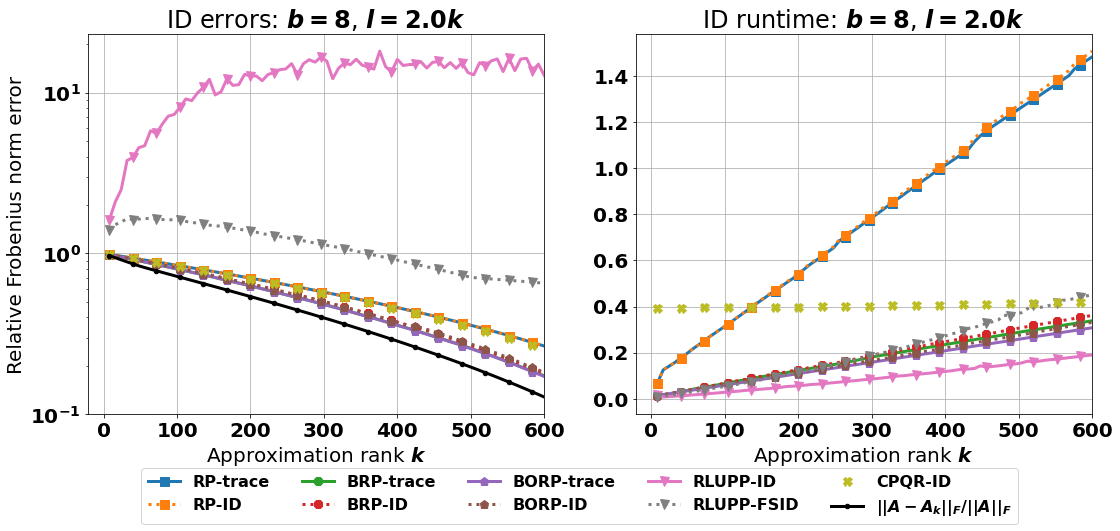

In [259]:
tag = f'id__{target_tag}'
plot_results(tag, oversampling, errors, times, ranks, max_x=600, markevery=4, savefig=True)

## Gaussian-poly1

In [264]:
target_tag = 'Gaussian-poly1'
oversampling=2.0
errors, times, ranks = compare_interpolation_errors(targets[target_tag], b=10, oversampling=oversampling, orthos=[], borthos=[0], cholid_modes=['rp'],)

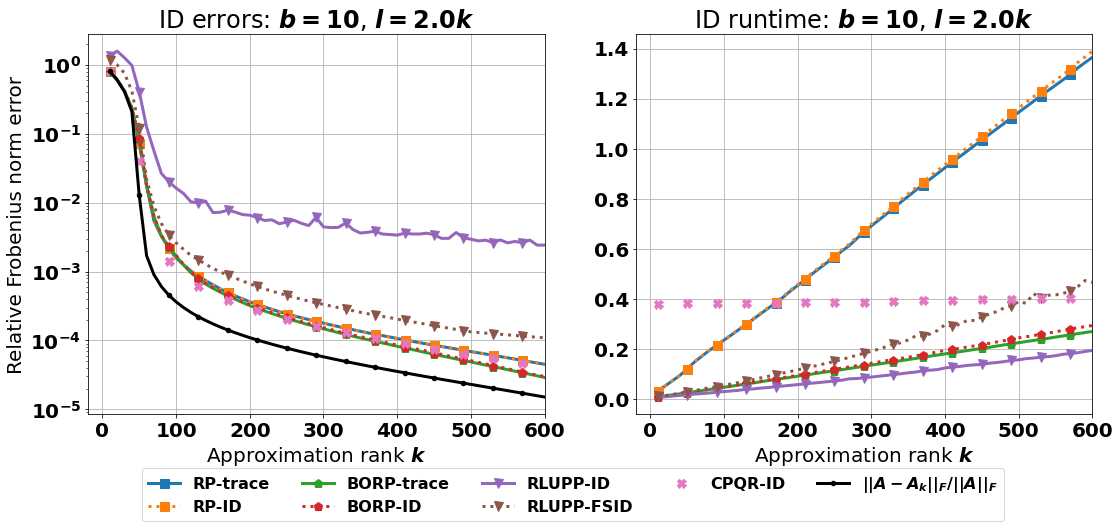

In [265]:
tag = f'id__{target_tag}'
plot_results(tag, oversampling, errors, times, ranks, max_x=600, markevery=4, savefig=True)

## Gaussian-exp

In [266]:
target_tag = 'Gaussian-exp'
oversampling=2.0
errors, times, ranks = compare_interpolation_errors(targets[target_tag], b=15, oversampling=oversampling, orthos=[], borthos=[0], cholid_modes=['rp'],)

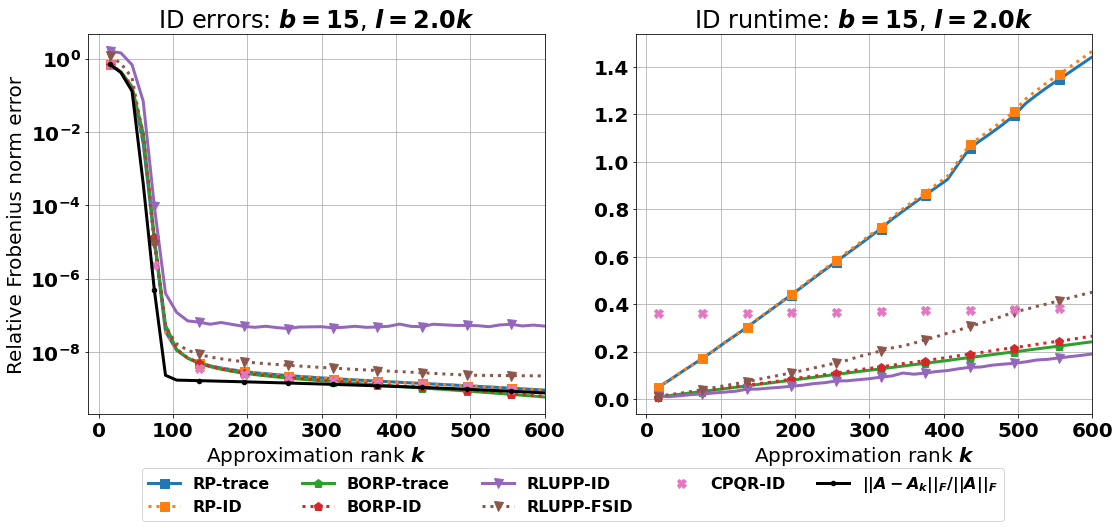

In [267]:
tag = f'id__{target_tag}'
plot_results(tag, oversampling, errors, times, ranks, max_x=600, markevery=4, savefig=True)

## SNN-r20a10

In [268]:
target_tag = 'SNN_m2000n1000r50a10'
oversampling=2.0
errors, times, ranks = compare_interpolation_errors(targets[target_tag], b=14, oversampling=oversampling, orthos=[], borthos=[0], cholid_modes=['rp'],)

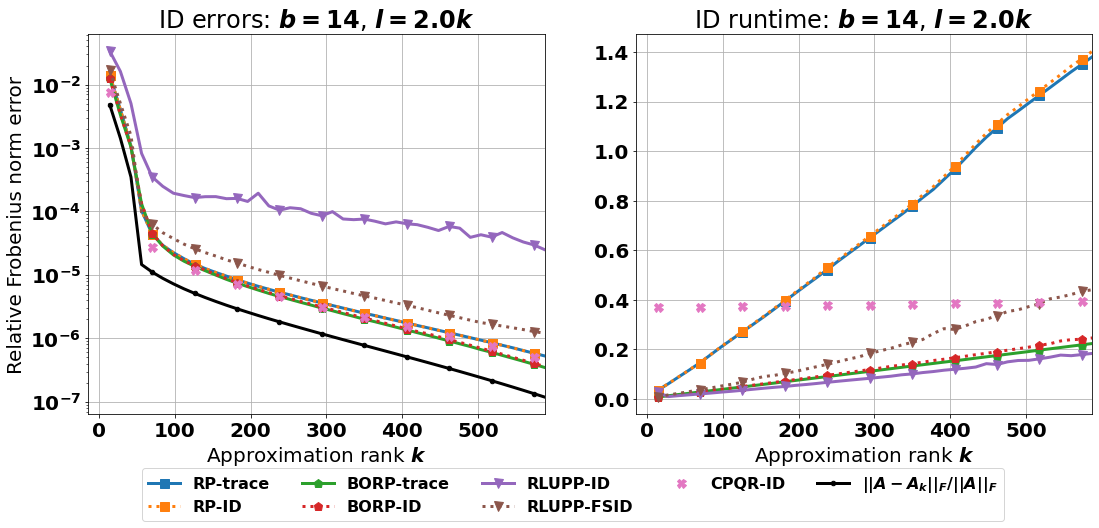

In [269]:
tag = f'id__{target_tag}'
plot_results(tag, oversampling, errors, times, ranks, max_x=600, markevery=4, savefig=True)

## SNN-r20a1

In [270]:
target_tag = 'SNN_m2000n1000r50a1'
oversampling=2.0
errors, times, ranks = compare_interpolation_errors(targets[target_tag], b=10, oversampling=oversampling, orthos=[], borthos=[0], cholid_modes=['rp'],)

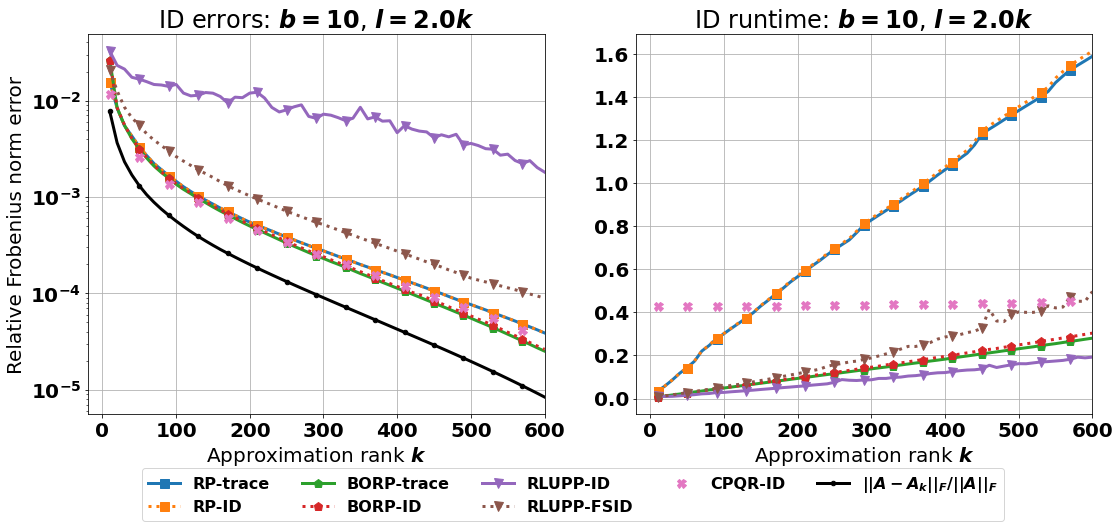

In [271]:
tag = f'id__{target_tag}'
plot_results(tag, oversampling, errors, times, ranks, max_x=600, markevery=4, savefig=True)

## MNIST

In [272]:
target_tag = 'MNIST'
oversampling=2.0
errors, times, ranks = compare_interpolation_errors(targets[target_tag], b=10, oversampling=oversampling, orthos=[], borthos=[0], cholid_modes=['rp'],)

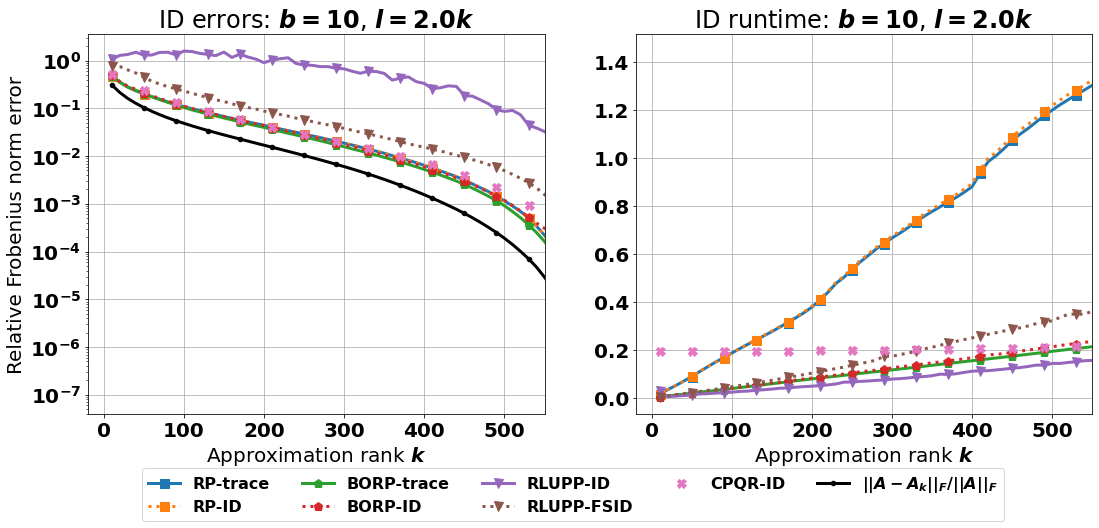

In [273]:
tag = f'id__{target_tag}'
plot_results(tag, oversampling, errors, times, ranks, max_x=550, markevery=4, savefig=True)

## CIFAR-10

In [276]:
target_tag = 'cifar10'
oversampling=2.0
errors, times, ranks = compare_interpolation_errors(targets[target_tag], b=8, oversampling=oversampling, orthos=[], borthos=[0], cholid_modes=['rp'],)

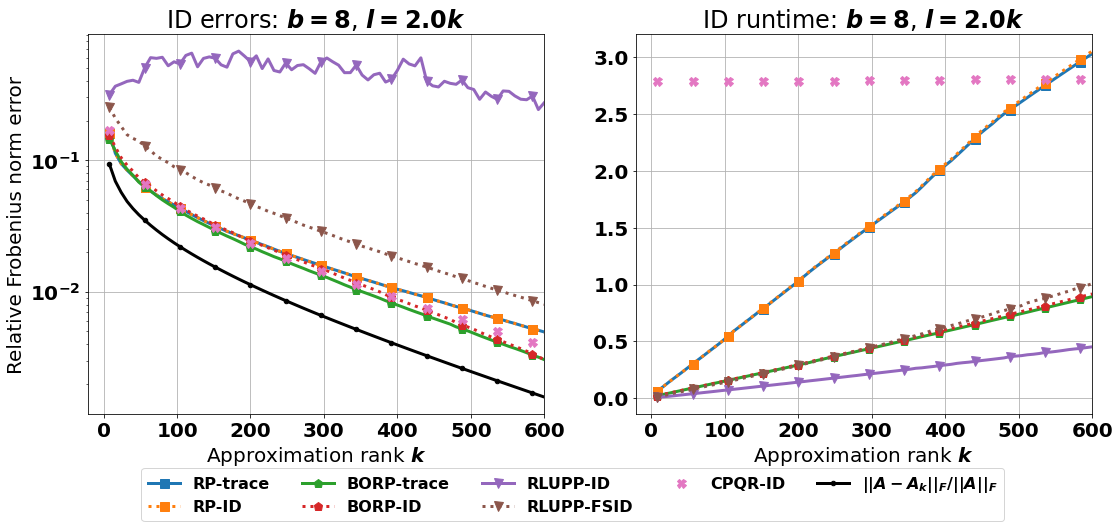

In [277]:
tag = f'id__{target_tag}'
plot_results(tag, oversampling, errors, times, ranks, max_x=600, markevery=6, savefig=True)

# Test skeletonization

## Gaussian-poly1

In [ ]:
target_tag = 'Gaussian-poly1'
oversampling=1.0
errors, times, ranks = compare_skeletonization_errors(targets[target_tag], b=10, oversampling=oversampling)
tag = f'ps__{target_tag}'
plot_results(tag, oversampling, errors, times, ranks, max_x=490, markevery=4, savefig=True)

## Gaussian-exp

In [ ]:
target_tag = 'Gaussian-exp'
oversampling=1.0
errors, times, ranks = compare_skeletonization_errors(targets[target_tag], oversampling=oversampling)
tag = f'ps__{target_tag}'
plot_results(tag, oversampling, errors, times, ranks, max_x=490, markevery=4, savefig=True)

## SNN-r20a10

In [ ]:
target_tag = 'SNN_m2000n500r40a10'
oversampling=1.0
errors, times, ranks = compare_skeletonization_errors(targets[target_tag], b=10, oversampling=oversampling)
plot_results(target_tag, oversampling, errors, times, ranks, max_x=490, markevery=4, savefig=True)

## SNN-r20a1

In [ ]:
target_tag = 'SNN_m2000n500r40a1'
oversampling=1.0
errors, times, ranks = compare_skeletonization_errors(targets[target_tag], b=10, oversampling=oversampling)
plot_results(target_tag, oversampling, errors, times, ranks, max_x=490, markevery=4, savefig=True)

## MNIST

In [ ]:
target_tag = 'MNIST'
oversampling=1.0
errors, times, ranks = compare_skeletonization_errors(targets[target_tag], oversampling=oversampling)
tag = f'ps__{target_tag}'
plot_results(tag, oversampling, errors, times, ranks, max_x=490, markevery=4, savefig=True)

## CIFAR-10

In [ ]:
target_tag = 'cifar10'
oversampling=1.0
errors, times, ranks = compare_skeletonization_errors(targets[target_tag], oversampling=oversampling)
tag = f'ps__{target_tag}'
plot_results(tag, oversampling, errors, times, ranks, max_x=490, markevery=4, savefig=True)